## Wine Reviews

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, concatenate, Input
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing.text import Tokenizer,text_to_word_sequence
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import callbacks

from google.colab import drive
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


Датасет взят с сайта Kaggle https://www.kaggle.com/zynicide/wine-reviews. Набор данных состоит из описания вина, места происхождения, цены и отзыва критика о нем. Изначально я предполагал использовать имеющиеся данные для предсказания цены на вино, но в процессе изучения данных выяснилось что они не совсем для этого подходят. Вторым вариантом было предсказание оценки, которую ставит критик данному вину. Тут проблема заключается в том, что, хоть оценки ставились по 100 бальной шкале, они все лежат в диапазоне от 80 до 100. Возможно, правильнее решать такую задачу с помощью классификации. Тем не менее я попробую проработать оба варианта и посмотреть что получится.

### Предсказание стоимости вина

In [ ]:
#Прочитаем данные
df = pd.read_csv('/content/drive/MyDrive/wine/winemag-data-130k-v2.csv',index_col=0)

In [ ]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [ ]:
#Посмотрим на данные
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


In [ ]:
#Удалим все строки в которых отсутствует цена (их не так много)
index_drop = df.loc[df.price != df.price].index
df.drop(index_drop, inplace=True)
#Большая часть цен лежит в диапозоне до 500 доларов. Я решил удалить строки, которые выше по цене, чтобы избежать выбросов в данных и улучшить визуализацию
df = df.loc[df.price < 500]
df.reset_index(inplace=True)

In [ ]:
#Датасет после удаления данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120870 entries, 0 to 120869
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  120870 non-null  int64  
 1   country                120811 non-null  object 
 2   description            120870 non-null  object 
 3   designation            86138 non-null   object 
 4   points                 120870 non-null  int64  
 5   price                  120870 non-null  float64
 6   province               120811 non-null  object 
 7   region_1               101313 non-null  object 
 8   region_2               50285 non-null   object 
 9   taster_name            96380 non-null   object 
 10  taster_twitter_handle  91468 non-null   object 
 11  title                  120870 non-null  object 
 12  variety                120869 non-null  object 
 13  winery                 120870 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [ ]:
#Создадим новый датафрейм в который будем записывать распарсенные данные
df_new=pd.DataFrame()

In [ ]:
#Заполним недостающие данные самой частой категорией и поменем текст на цифры
df['country'].fillna('US', inplace=True) 
uniq_country = df['country'].unique()
dict_country = dict(zip(uniq_country, range(len(uniq_country))))
df_new['country'] = df['country'].map(dict_country).values

In [ ]:
#Столбец designation распрсим следующим образом. 
#0 - если в обозначении нет слова Reserve
#1 - есть слово Reserve
#Предполагаю, что вино Reserve должно стоить больше
reserve = []
for i in df['designation']:
  if str(i) == 'nan':
    reserve.append(0)  
  elif 'Reserve' in i:
    reserve.append(1)
  else:
    reserve.append(0)

df_new['reserve'] = reserve

In [ ]:
# Points запишем как есть и закодируем в дальнейшем с помощью OneHotEncoding
df_new['points'] = df['points']

In [ ]:
#Заполним недостающие данные категорией NA и поменем текст на цифры
df['variety'].fillna('NA', inplace=True) 
uniq_variety = df['variety'].unique()
dict_variety = dict(zip(uniq_variety, range(len(uniq_variety))))
df_new['variety'] = df['variety'].map(dict_variety).values

In [ ]:
#Закодируем категориальные данные с помощью OneHotEncoding
x_data = pd.get_dummies(df_new, columns = ['country',	'reserve', 'points', 'variety'])

In [ ]:
#Заполним недостающие данные категорией No
x_data['description'] = df['description']
for i, j in enumerate(x_data['description']):
  try: j.lower()
  except: x_data.loc[i,'description'] = 'No'


Столбцы region_1, region_2, winery не будем рассматривать так как они содержат очень много различных данных и возможно излишни.
Столбец taster_twitter_handle, taster_name содержат информацию, которая не влияет на цену.
Столбец title повторяет designation.

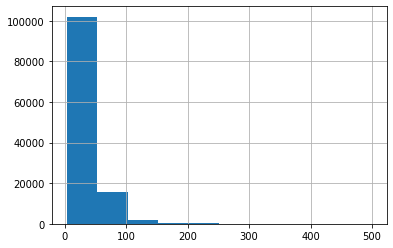

In [ ]:
#Посмотрим на распределение данных о цене
df['price'].hist()
#Распределение похоже на экспоненциальное

In [ ]:
#Попробуем логорифмировать цену, чтобы приблизить его к нормальному
logg = []
for i in df['price']:
  logg.append(np.log(i))

x_data['y_scale'] = logg

(array([  177.,  6103., 25422., 32473., 27994., 19700.,  6430.,  1856.,
          515.,   200.]),
 array([1.38629436, 1.86892553, 2.35155671, 2.83418788, 3.31681905,
        3.79945023, 4.2820814 , 4.76471258, 5.24734375, 5.72997492,
        6.2126061 ]),
 <a list of 10 Patch objects>)

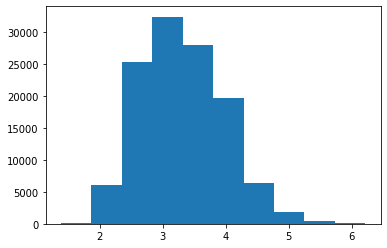

In [ ]:
plt.hist(x_data['y_scale'])
#Как видим, задумка удалась

In [ ]:
#Разделим выборку на обучающую и проверочную
x_train, x_test, y_train, y_test = train_test_split(x_data.iloc[:,:-1], x_data.y_scale, shuffle=True, test_size=0.2)

In [ ]:
# Отделим текстовые данные
x_train_numeric = x_train.iloc[:,:-1]
x_train_word = x_train.iloc[:,-1].values

x_test_numeric = x_test.iloc[:,:-1]
x_test_word = x_test.iloc[:,-1].values

In [ ]:
#Создадим словарь и распарсим текстовые данные при помощи мешка слов
max_word=3000
tokenizer = Tokenizer(max_word, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token='Unknown')
tokenizer.fit_on_texts(x_train_word)

x_train_vec = tokenizer.texts_to_matrix(x_train_word)
x_test_vec = tokenizer.texts_to_matrix(x_test_word)

In [ ]:
#Функция возвращает среднюю абсолютную ошибку и график scatter plot
def mae_scatter_price(model, data):
  pred = model.predict(data) 
  exp_pred = np.exp(pred).flatten()
  exp_test = np.exp(y_test)

  dif = exp_test.values-exp_pred
  abs_dif = abs(dif)
  sum_dif = sum(abs_dif)
  print("MAE: ", sum_dif / len(exp_test))

  plt.scatter(exp_pred, exp_test)
  plt.xlabel('Предсказаная цена, тыс.руб.')
  plt.ylabel('Настоящая цена, тыс.руб.')
  plt.plot([0, 500], [0, 500])

In [ ]:
# Так как оценивать качество модели мы будем метрикой MAE, в качестве отправной точки можно использовать медианное значение тестовой выборки. 
# Посмотрим какое MAE получится, если вместо предсказанных значений подставить медиану
exp_test = np.exp(y_test)
dif = exp_test.values-np.median(exp_test)
abs_dif = abs(dif)
sum_dif = sum(abs_dif)
print("MAE: ", sum_dif / len(exp_test))

MAE:  17.810829817158933


Посмотрим насколько наша модель сможет превзойти это значение

In [ ]:
#Модель только с числовыми значениями
model_num=Sequential()
model_num.add(Dense(200, activation="relu", input_dim=x_train_numeric.shape[1]))
model_num.add(Dense(100, activation="relu"))
model_num.add(Dense(1, activation="linear"))
model_num.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mae'])
model_num.fit(x_train_numeric.values, y_train.values, epochs=20, batch_size=256, validation_data=(x_test_numeric.values, y_test.values), verbose=1)

# model_num.compile(loss='mse', optimizer=SGD(lr=0.001), metrics=['mae'])
# model_num.fit(x_train_numeric.values, y_train.values, epochs=20, batch_size=256, validation_data=(x_test_numeric.values, y_test.values), verbose=1)

Epoch 1/20
378/378 [==============================] - 4s 9ms/step - loss: 1.6069 - mae: 0.8176 - val_loss: 0.1885 - val_mae: 0.3367
Epoch 2/20
378/378 [==============================] - 3s 9ms/step - loss: 0.1819 - mae: 0.3283 - val_loss: 0.1830 - val_mae: 0.3285
Epoch 3/20
378/378 [==============================] - 3s 8ms/step - loss: 0.1745 - mae: 0.3207 - val_loss: 0.1811 - val_mae: 0.3275
Epoch 4/20
378/378 [==============================] - 3s 9ms/step - loss: 0.1719 - mae: 0.3184 - val_loss: 0.1820 - val_mae: 0.3298
Epoch 5/20
378/378 [==============================] - 3s 9ms/step - loss: 0.1717 - mae: 0.3175 - val_loss: 0.1810 - val_mae: 0.3264
Epoch 6/20
378/378 [==============================] - 3s 8ms/step - loss: 0.1692 - mae: 0.3156 - val_loss: 0.1825 - val_mae: 0.3300
Epoch 7/20
378/378 [==============================] - 3s 8ms/step - loss: 0.1707 - mae: 0.3168 - val_loss: 0.1806 - val_mae: 0.3275
Epoch 8/20
378/378 [==============================] - 4s 11ms/step - loss: 0

MAE:  11.999575991897634


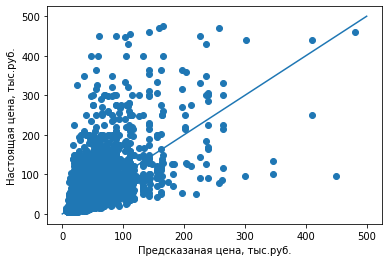

In [ ]:
mae_scatter_price(model_num, x_test_numeric, 0, 500)

In [ ]:
#Модель только с текстовыми значениями
input_vec = Input(x_train_vec.shape[1],)
x = Dense(500, activation='relu')(input_vec)
x = Dropout(0.2)(x)
# x = BatchNormalization()(x)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(1)(x)
model_vec = Model(input_vec,output)

model_vec.compile(loss='mse', optimizer=SGD(lr=0.001), metrics=['mae'])
model_vec.fit(x_train_vec, y_train, epochs=20, batch_size=256, validation_data=(x_test_vec, y_test), verbose=1)

Epoch 1/20
378/378 [==============================] - 16s 42ms/step - loss: 0.2719 - mae: 0.4082 - val_loss: 0.2702 - val_mae: 0.4012
Epoch 2/20
378/378 [==============================] - 16s 42ms/step - loss: 0.2743 - mae: 0.4083 - val_loss: 0.2705 - val_mae: 0.4011
Epoch 3/20
378/378 [==============================] - 16s 41ms/step - loss: 0.2716 - mae: 0.4076 - val_loss: 0.2661 - val_mae: 0.3992
Epoch 4/20
378/378 [==============================] - 16s 41ms/step - loss: 0.2678 - mae: 0.4039 - val_loss: 0.2663 - val_mae: 0.3988
Epoch 5/20
378/378 [==============================] - 16s 41ms/step - loss: 0.2688 - mae: 0.4053 - val_loss: 0.2635 - val_mae: 0.3977
Epoch 6/20
378/378 [==============================] - 16s 41ms/step - loss: 0.2664 - mae: 0.4033 - val_loss: 0.2645 - val_mae: 0.3972
Epoch 7/20
378/378 [==============================] - 16s 42ms/step - loss: 0.2667 - mae: 0.4032 - val_loss: 0.2640 - val_mae: 0.3968
Epoch 8/20
378/378 [==============================] - 16s 42ms

MAE:  14.429900817187812


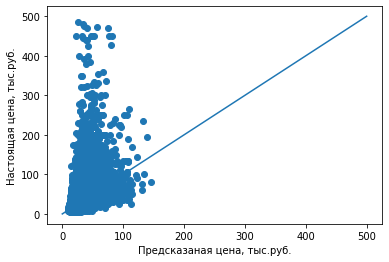

In [ ]:
mae_scatter_price(model_vec, x_test_vec, 0, 500)

In [ ]:
#Модель со всеми значениями
input_num = Input(x_train_numeric.shape[1],)
input_vec = Input(x_train_vec.shape[1],)
x1 = Dense(200, activation='relu')(input_num)
x2 = Dense(500, activation='relu')(input_vec)

x = concatenate([x1,x2])

x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)

# x = Dense(20, activation='relu')(x)
# x = Dropout(0.2)(x)
# x = BatchNormalization()(x)
output = Dense(1)(x)
model = Model((input_num,input_vec),output)

model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mae'])
model.fit([x_train_numeric, x_train_vec], y_train, epochs=10, batch_size=256, validation_data=([x_test_numeric,x_test_vec], y_test), verbose=1)

model.compile(loss='mse', optimizer=Adam(lr=0.00001), metrics=['mae'])
model.fit([x_train_numeric, x_train_vec], y_train, epochs=5, batch_size=256, validation_data=([x_test_numeric,x_test_vec], y_test), verbose=1)

Epoch 1/5
378/378 [==============================] - 23s 59ms/step - loss: 2.6665e-04 - mae: 0.0119 - val_loss: 0.1432 - val_mae: 0.2725
Epoch 2/5
378/378 [==============================] - 22s 58ms/step - loss: 1.6495e-04 - mae: 0.0091 - val_loss: 0.1432 - val_mae: 0.2723
Epoch 3/5
378/378 [==============================] - 22s 58ms/step - loss: 1.1800e-04 - mae: 0.0074 - val_loss: 0.1432 - val_mae: 0.2721
Epoch 4/5
378/378 [==============================] - 22s 59ms/step - loss: 8.0216e-05 - mae: 0.0061 - val_loss: 0.1431 - val_mae: 0.2719
Epoch 5/5
378/378 [==============================] - 22s 59ms/step - loss: 6.9585e-05 - mae: 0.0051 - val_loss: 0.1432 - val_mae: 0.2719


MAE:  10.288596384300629


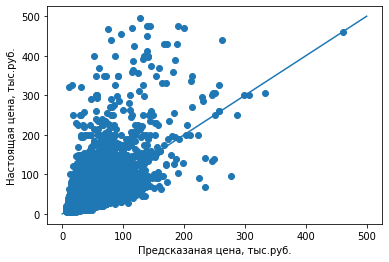

In [ ]:
mae_scatter_price(model, [x_test_numeric, x_test_vec], 0, 500)

Результат не очень хороший, но заметно лучше константного значения

###Предсказание оценки критиков

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/wine/winemag-data-130k-v2.csv',index_col=0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


In [ ]:
#Создадим новый датафрейм в который будем записывать распарсенные данные
df_new=pd.DataFrame()

In [ ]:
#Заполним недостающие данные самой частой категорией и поменем текст на цифры
df['country'].fillna('US', inplace=True) 
uniq_country = df['country'].unique()
dict_country = dict(zip(uniq_country, range(len(uniq_country))))
df_new['country'] = df['country'].map(dict_country).values

In [ ]:
#Столбец designation распрсим следующим образом. 
#0 - если в обозначении нет слова Reserve
#1 - есть слово Reserve
#Предполагаю, что вино Reserve должно стоить больше
reserve = []
for i in df['designation']:
  if str(i) == 'nan':
    reserve.append(0)  
  elif 'Reserve' in i:
    reserve.append(1)
  else:
    reserve.append(0)

df_new['reserve'] = reserve

In [ ]:
#Заполним недостающие данные средним значением и нормализуем данные
df['price'].fillna(df['price'].mean(), inplace=True)
price_scaler=StandardScaler()
price = price_scaler.fit_transform(df['price'].values.reshape(-1,1))
df_new['price'] = price

In [ ]:
#Заполним недостающие данные новой категорией Unknown и заменим текст на цифры
df['taster_name'].fillna('Unknown', inplace=True) 
uniq_name = df['taster_name'].unique()
dict_name = dict(zip(uniq_name, range(len(uniq_name))))
df_new['taster_name'] = df['taster_name'].map(dict_name).values

In [ ]:
#Заполним недостающие данные категорией NA и поменяем текст на цифры
df['variety'].fillna('NA', inplace=True) 
uniq_variety = df['variety'].unique()
dict_variety = dict(zip(uniq_variety, range(len(uniq_variety))))
df_new['variety'] = df['variety'].map(dict_variety).values

In [ ]:
#Закодируем категориальные данные с помощью OneHotEncoding
x_data = pd.get_dummies(df_new, columns = ['country',	'reserve', 'variety','taster_name'])

In [ ]:
#Заполним недостающие данные категорией No
x_data['description'] = df['description']
for i, j in enumerate(x_data['description']):
  try: j.lower()
  except: x_data.loc[i,'description'] = 'No'

#нормализуем оценки критиков
y = df['points']
y_scaler = StandardScaler()
x_data['y_scale'] = y_scaler.fit_transform(y.values.reshape(-1,1))


In [ ]:
#Разделим выборку на обучающую и проверочную
x_train, x_test, y_train, y_test = train_test_split(x_data.iloc[:,:-1], x_data.y_scale, shuffle=True, test_size=0.2)

In [ ]:
# Отделим текстовые данные
x_train_numeric = x_train.iloc[:,:-1]
x_train_word = x_train.iloc[:,-1].values

x_test_numeric = x_test.iloc[:,:-1]
x_test_word = x_test.iloc[:,-1].values

In [ ]:
#Создадим словарь и распарсим текстовые данные при помощи мешка слов
max_word=3000
tokenizer = Tokenizer(max_word, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token='Unknown')
tokenizer.fit_on_texts(x_train_word)

x_train_vec = tokenizer.texts_to_matrix(x_train_word)
x_test_vec = tokenizer.texts_to_matrix(x_test_word)

In [ ]:
#Функция возвращает среднюю абсолютную ошибку и график scatter plot
def mae_scatter_point(model, data):
  pred = model.predict(data) 
  scaler_pred = y_scaler.inverse_transform(pred).flatten()
  scaler_test = y_scaler.inverse_transform(y_test).flatten()

  dif = scaler_test-scaler_pred
  abs_dif = abs(dif)
  sum_dif = sum(abs_dif)
  print("MAE: ", sum_dif / len(scaler_test))

  plt.scatter(scaler_pred, scaler_test)
  plt.xlabel('Предсказаная цена, тыс.руб.')
  plt.ylabel('Настоящая цена, тыс.руб.')
  plt.plot([79, 100], [79, 100])


In [ ]:
# Так как оценивать качество модели мы будем метрикой MAE, в качестве отправной точки можно использовать медианное значение тестовой выборки. 
# Посмотрим какое MAE получится, если вместо предсказанных значений подставить медиану
scaler_test = y_scaler.inverse_transform(y_test).flatten()
dif = scaler_test-np.median(scaler_test)
abs_dif = abs(dif)
sum_dif = sum(abs_dif)
print("MAE: ", sum_dif / len(exp_test))

MAE:  2.4522792844777843


In [ ]:
#Модель только с числовыми значениями
model_num=Sequential()
model_num.add(Dense(200, activation="relu", input_dim=x_train_numeric.shape[1]))
# model_num.add(BatchNormalization())
model_num.add(Dense(100, activation="relu"))
# model_num.add(Dense(50, activation="relu"))
model_num.add(Dense(1, activation="linear"))
model_num.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mae'])
model_num.fit(x_train_numeric, y_train, epochs=20, batch_size=256, validation_data=(x_test_numeric, y_test), verbose=1)

model.compile(loss='mse', optimizer=Adam(lr=0.0001), metrics=['mae'])
model_num.fit(x_train_numeric, y_train, epochs=10, batch_size=256, validation_data=(x_test_numeric, y_test), verbose=1)

Epoch 1/20
407/407 [==============================] - 5s 12ms/step - loss: 0.6471 - mae: 0.6333 - val_loss: 0.5550 - val_mae: 0.5902
Epoch 2/20
407/407 [==============================] - 4s 10ms/step - loss: 0.5563 - mae: 0.5881 - val_loss: 0.5511 - val_mae: 0.5841
Epoch 3/20
407/407 [==============================] - 5s 13ms/step - loss: 0.5341 - mae: 0.5758 - val_loss: 0.5419 - val_mae: 0.5816
Epoch 4/20
407/407 [==============================] - 4s 11ms/step - loss: 0.5392 - mae: 0.5777 - val_loss: 0.5413 - val_mae: 0.5836
Epoch 5/20
407/407 [==============================] - 4s 10ms/step - loss: 0.5338 - mae: 0.5746 - val_loss: 0.5385 - val_mae: 0.5822
Epoch 6/20
407/407 [==============================] - 4s 9ms/step - loss: 0.5329 - mae: 0.5742 - val_loss: 0.5354 - val_mae: 0.5775
Epoch 7/20
407/407 [==============================] - 5s 11ms/step - loss: 0.5258 - mae: 0.5693 - val_loss: 0.5377 - val_mae: 0.5786
Epoch 8/20
407/407 [==============================] - 4s 10ms/step - l

MAE:  1.7443544121104082


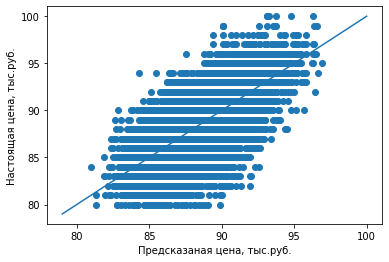

In [ ]:
mae_scatter_point(model_num, x_test_numeric)

In [ ]:
#Модель только с текстовыми значениями
input_vec = Input(x_train_vec.shape[1],)
x = Dense(500, activation='relu')(input_vec)
# x = Dropout(0.2)(x)
# x = BatchNormalization()(x)
x = Dense(100, activation='relu')(x)
# x = BatchNormalization()(x)
output = Dense(1)(x)
model_vec = Model(input_vec,output)

model_vec.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mae'])
model_vec.fit(x_train_vec, y_train, epochs=20, batch_size=256, validation_data=(x_test_vec, y_test), verbose=1)

model_vec.compile(loss='mse', optimizer=Adam(lr=0.0001), metrics=['mae'])
model_vec.fit(x_train_vec, y_train, epochs=10, batch_size=256, validation_data=(x_test_vec, y_test), verbose=1)

Epoch 1/10
407/407 [==============================] - 18s 43ms/step - loss: 0.0089 - mae: 0.0710 - val_loss: 0.2492 - val_mae: 0.3733
Epoch 2/10
407/407 [==============================] - 19s 47ms/step - loss: 0.0043 - mae: 0.0490 - val_loss: 0.2493 - val_mae: 0.3721
Epoch 3/10
407/407 [==============================] - 19s 47ms/step - loss: 0.0025 - mae: 0.0368 - val_loss: 0.2489 - val_mae: 0.3706
Epoch 4/10
407/407 [==============================] - 17s 43ms/step - loss: 0.0014 - mae: 0.0276 - val_loss: 0.2486 - val_mae: 0.3696
Epoch 5/10
407/407 [==============================] - 17s 43ms/step - loss: 8.0883e-04 - mae: 0.0206 - val_loss: 0.2489 - val_mae: 0.3692
Epoch 6/10
407/407 [==============================] - 21s 52ms/step - loss: 4.8988e-04 - mae: 0.0151 - val_loss: 0.2487 - val_mae: 0.3686
Epoch 7/10
407/407 [==============================] - 17s 43ms/step - loss: 2.9872e-04 - mae: 0.0110 - val_loss: 0.2488 - val_mae: 0.3682
Epoch 8/10
407/407 [==============================

MAE:  1.1180965751564302


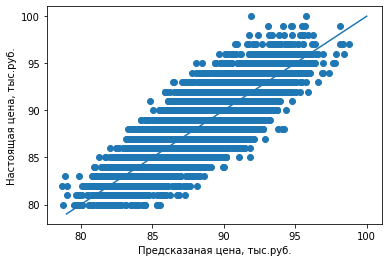

In [ ]:
mae_scatter_point(model_vec, x_test_vec)

In [ ]:
#Создадим модель со всеми данными
input_num = Input(x_train_numeric.shape[1],)
input_vec = Input(x_train_vec.shape[1],)
x1 = Dense(200, activation='relu')(input_num)
x2 = Dense(500, activation='relu')(input_vec)
x = concatenate([x1,x2])

x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)
# x = Dense(20, activation='relu')(x)
x = Dropout(0.2)(x)
# x = BatchNormalization()(x)
output = Dense(1)(x)
model = Model((input_num,input_vec),output)

model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mae'])
model.fit([x_train_numeric, x_train_vec], y_train, epochs=20, batch_size=256, validation_data=([x_test_numeric,x_test_vec], y_test), verbose=1)

model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mae'])
model.fit([x_train_numeric, x_train_vec], y_train, epochs=10, batch_size=256, validation_data=([x_test_numeric,x_test_vec], y_test), verbose=1)

Epoch 1/10
407/407 [==============================] - 23s 54ms/step - loss: 0.0196 - mae: 0.1018 - val_loss: 0.2006 - val_mae: 0.3330
Epoch 2/10
407/407 [==============================] - 21s 53ms/step - loss: 0.0197 - mae: 0.1023 - val_loss: 0.2009 - val_mae: 0.3330
Epoch 3/10
407/407 [==============================] - 22s 53ms/step - loss: 0.0191 - mae: 0.1003 - val_loss: 0.1999 - val_mae: 0.3327
Epoch 4/10
407/407 [==============================] - 22s 54ms/step - loss: 0.0191 - mae: 0.1002 - val_loss: 0.1999 - val_mae: 0.3320
Epoch 5/10
407/407 [==============================] - 21s 51ms/step - loss: 0.0191 - mae: 0.1002 - val_loss: 0.2016 - val_mae: 0.3335
Epoch 6/10
407/407 [==============================] - 21s 51ms/step - loss: 0.0193 - mae: 0.1006 - val_loss: 0.1992 - val_mae: 0.3312
Epoch 7/10
407/407 [==============================] - 22s 53ms/step - loss: 0.0183 - mae: 0.0978 - val_loss: 0.2004 - val_mae: 0.3323
Epoch 8/10
407/407 [==============================] - 22s 53ms

MAE:  1.0066432699741688


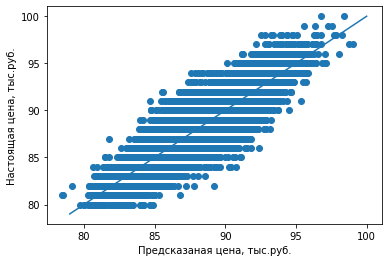

In [ ]:
mae_scatter_point(model, [x_test_numeric,x_test_vec])

Можно было еще попробовать немного улучшить качество, но блокнот вылетает из-за ограничений памяти. В целом мы получили хороший результат, более чем в два раза улучшив модель с константным значением.

Ради интереса попробуем решить эту задачу с помощью классификации

In [ ]:
#Закодируем категориальные данные с помощью OneHotEncoding
x_data = pd.get_dummies(df_new, columns = ['country',	'reserve', 'variety','taster_name'])

In [ ]:
#Заполним недостающие данные категорией No
x_data['description'] = df['description']
for i, j in enumerate(x_data['description']):
  try: j.lower()
  except: x_data.loc[i,'description'] = 'No'

#нормализуем оценки критиков
x_data['y_scale'] = df['points'].values - 80


In [ ]:
#Разделим выборку на обучающую и проверочную
x_train, x_test, y_train, y_test = train_test_split(x_data.iloc[:,:-1], x_data.y_scale, shuffle=True, test_size=0.2)

In [ ]:
# Отделим текстовые данные
x_train_numeric = x_train.iloc[:,:-1]
x_train_word = x_train.iloc[:,-1].values

x_test_numeric = x_test.iloc[:,:-1]
x_test_word = x_test.iloc[:,-1].values

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train1 = to_categorical(y_train, 21)
y_test1 = to_categorical(y_test, 21)

In [ ]:
#Создадим словарь и распарсим текстовые данные при помощи мешка слов
max_word=3000
tokenizer = Tokenizer(max_word, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token='Unknown')
tokenizer.fit_on_texts(x_train_word)

x_train_vec = tokenizer.texts_to_matrix(x_train_word)
x_test_vec = tokenizer.texts_to_matrix(x_test_word)

In [ ]:
#Создадим модель со всеми данными
input_num = Input(x_train_numeric.shape[1],)
input_vec = Input(x_train_vec.shape[1],)
x1 = Dense(200, activation='relu')(input_num)
x2 = Dense(500, activation='relu')(input_vec)
x = concatenate([x1,x2])
# x = Dense(100, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)
# x = Dropout(0.2)(x)
# x = BatchNormalization()(x)
output = Dense(21, activation='softmax')(x)
model = Model((input_num,input_vec),output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.fit([x_train_numeric, x_train_vec], y_train1, epochs=10, batch_size=256, validation_data=([x_test_numeric,x_test_vec], y_test1), verbose=1)

Epoch 1/5
407/407 [==============================] - 19s 46ms/step - loss: 0.0352 - accuracy: 0.9936 - val_loss: 5.2294 - val_accuracy: 0.3515
Epoch 2/5
407/407 [==============================] - 18s 44ms/step - loss: 0.0143 - accuracy: 0.9989 - val_loss: 5.3682 - val_accuracy: 0.3515
Epoch 3/5
407/407 [==============================] - 18s 44ms/step - loss: 0.0093 - accuracy: 0.9995 - val_loss: 5.5321 - val_accuracy: 0.3524
Epoch 4/5
407/407 [==============================] - 18s 44ms/step - loss: 0.0068 - accuracy: 0.9996 - val_loss: 5.6302 - val_accuracy: 0.3525
Epoch 5/5
407/407 [==============================] - 18s 44ms/step - loss: 0.0053 - accuracy: 0.9998 - val_loss: 5.7462 - val_accuracy: 0.3521


MAE:  1.1262935179842277


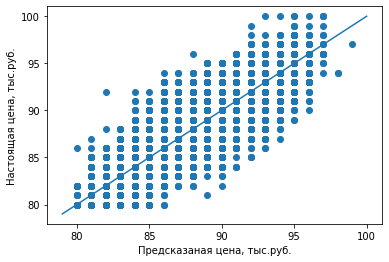

In [ ]:
pred = model.predict([x_test_numeric,x_test_vec]) 

cat_pred=[]
for i in pred:
  cat_pred.append(np.argmax(i))

scaler_pred = np.array(cat_pred)+80
scaler_test = y_test + 80

dif = scaler_test-scaler_pred
abs_dif = abs(dif)
sum_dif = sum(abs_dif)
print("MAE: ", sum_dif / len(scaler_test))

plt.scatter(scaler_pred, scaler_test)
plt.xlabel('Предсказаная цена, тыс.руб.')
plt.ylabel('Настоящая цена, тыс.руб.')
plt.plot([79, 100], [79, 100])

Вывод: В ходе экспериментов было обучено много разных моделей. Во всех случаях модели с числовыми и текстовыми данными показали себя лучше всего. Нам удалось обучить модели, которые предсказывают значения значимо лучше чем константные значения. Теория о том, что оценки критиков лучше предсказывать с помощью классификации не оправдалась, но значение MAE получилось достаточно близкое.  

Варианты улучшения модели:
1) Получше очистить входные данные, поэкспериментировать с различными вариантами парсинга, попробовать разное заполнение пропусков (возможно удаление строк где есть пропуски), как-то добавить неучтенные признаки.  
2) Попробовать обработать текстовые признаки с помощью эмбедингов и обучить LSTM модель.